$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bm}[1]{{\bf #1}}
\newcommand{\bb}[1]{\bm{\mathrm{#1}}}
$$

# Part 3: Generative Adversarial Networks
<a id=part3></a>

In this part we will implement and train a generative adversarial network and apply it to the task of image generation.

In [1]:
import unittest
import os
import sys
import pathlib
import urllib
import shutil
import re
import zipfile

import numpy as np
import torch
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

test = unittest.TestCase()
plt.rcParams.update({'font.size': 12})
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


### Obtaining the dataset
<a id=part3_1></a>

We'll use the same data as in Part 2.

But again, you can use a custom dataset, by editing the `PART3_CUSTOM_DATA_URL` variable in `hw3/answers.py`.

In [2]:
import cs236781.plot as plot
import cs236781.download
from hw3.answers import PART3_CUSTOM_DATA_URL as CUSTOM_DATA_URL

DATA_DIR = pathlib.Path.home().joinpath('.pytorch-datasets')
if CUSTOM_DATA_URL is None:
    DATA_URL = 'http://vis-www.cs.umass.edu/lfw/lfw-bush.zip'
else:
    DATA_URL = CUSTOM_DATA_URL

_, dataset_dir = cs236781.download.download_data(out_path=DATA_DIR, url=DATA_URL, extract=True, force=False)

Saved to C:\Users\Aviv\.pytorch-datasets\lfw-bush.zip.
Extracting C:\Users\Aviv\.pytorch-datasets\lfw-bush.zip...
Extracted 531 to C:\Users\Aviv\.pytorch-datasets\lfw/George_W_Bush


Create a `Dataset` object that will load the extraced images:

In [3]:
import torchvision.transforms as T
from torchvision.datasets import ImageFolder

im_size = 64
tf = T.Compose([
    # Resize to constant spatial dimensions
    T.Resize((im_size, im_size)),
    # PIL.Image -> torch.Tensor
    T.ToTensor(),
    # Dynamic range [0,1] -> [-1, 1]
    T.Normalize(mean=(.5,.5,.5), std=(.5,.5,.5)),
])

ds_gwb = ImageFolder(os.path.dirname(dataset_dir), tf)

OK, let's see what we got. You can run the following block multiple times to display a random subset of images from the dataset.

Found 530 images in dataset folder.


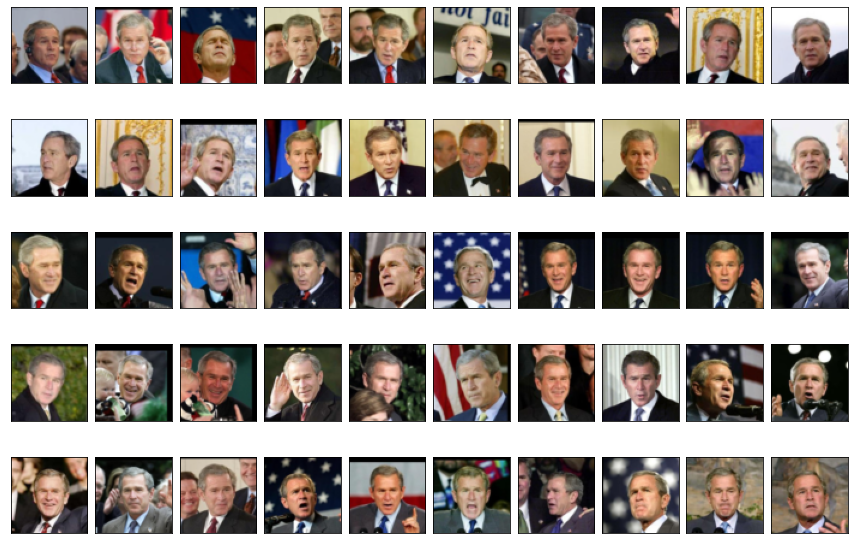

In [4]:
_ = plot.dataset_first_n(ds_gwb, 50, figsize=(15,10), nrows=5)
print(f'Found {len(ds_gwb)} images in dataset folder.')

In [5]:
x0, y0 = ds_gwb[0]
x0 = x0.unsqueeze(0).to(device)
print(x0.shape)

test.assertSequenceEqual(x0.shape, (1, 3, im_size, im_size))

torch.Size([1, 3, 64, 64])


## Generative Adversarial Nets (GANs)
<a id=part3_2></a>

GANs, first proposed in a [paper](https://arxiv.org/pdf/1406.2661.pdf) by Ian Goodfellow in 2014 are today arguably the most popular type of generative model. GANs are currently producing state of the art
results in generative tasks over many different domains.

In a GAN model, two different neural networks compete against each other: A **generator** and a **discriminator**.

- The Generator, which we'll denote as $\Psi _{\bb{\gamma}} : \mathcal{U} \rightarrow \mathcal{X}$, maps a latent-space variable
$\bb{u}\sim\mathcal{N}(\bb{0},\bb{I})$ to an instance-space variable $\bb{x}$ (e.g. an image).
Thus a parametric evidence distribution $p_{\bb{\gamma}}(\bb{X})$ is generated,
which we typically would like to be as close as possible to the real evidence distribution, $p(\bb{X})$.

- The Discriminator, $\Delta _{\bb{\delta}} : \mathcal{X} \rightarrow [0,1]$, is a network which,
given an instance-space variable $\bb{x}$, returns the  probability that $\bb{x}$ is real, i.e. that $\bb{x}$
was sampled from $p(\bb{X})$ and not $p_{\bb{\gamma}}(\bb{X})$.


<img src="imgs/gan.jpg" />

### Training GANs
<a id=part3_3></a>

The generator is trained to generate "fake" instances which will maximally fool the
discriminator into returning that they're real. Mathematically, the generator's parameters
$\bb{\gamma}$ should be chosen such as to **maximize** the expression
$$
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

The discriminator is trained to classify between real images, coming from the training set,
and fake images generated by the generator.
Mathematically, the discriminator's parameters $\bb{\delta}$ should be chosen such as to
**maximize** the expression
$$
\mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

These two competing objectives can thus be expressed as the following min-max optimization:
$$
\min _{\bb{\gamma}} \max _{\bb{\delta}} \,
\mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

A key insight into GANs is that we can interpret the above maximum as the *loss* with respect to
$\bb{\gamma}$:

$$
L({\bb{\gamma}}) =
\max _{\bb{\delta}} \, \mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
  \mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

This means that the generator's loss function trains together with the generator
itself in an adversarial manner. In contrast, when training our VAE we used a fixed L2 norm
as a data loss term.

### Model Implementation
<a id=part3_4></a>

We'll now implement a Deep Convolutional GAN (DCGAN) model.
See the DCGAN [paper](https://arxiv.org/pdf/1511.06434.pdf) for architecture ideas and tips for training.

**TODO**: Implement the `Discriminator` class in the `hw3/gan.py` module.
If you wish you can reuse the `EncoderCNN` class from the VAE model as the first part of the Discriminator.

In [6]:
import hw3.gan as gan

dsc = gan.Discriminator(in_size=x0[0].shape).to(device)
print(dsc)

d0 = dsc(x0)
print(d0.shape)

test.assertSequenceEqual(d0.shape, (1,1))

Discriminator(
  (encoder): EncoderCNN(
    (cnn): Sequential(
      (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(2, 2))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2))
      (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU()
      (9): Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1))
      (10): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): ReLU()
    )
  )
  (linear_layer): Linear(in_features=1024, out_features=1, bias=True)
)
torch.Size([1, 1])


**TODO**: Implement the `Generator` class in the `hw3/gan.py` module.
If you wish you can reuse the `DecoderCNN` class from the VAE model as the last part of the Generator.

In [7]:
z_dim = 128
gen = gan.Generator(z_dim, 4).to(device)
print(gen)

z = torch.randn(1, z_dim).to(device)
xr = gen(z)
print(xr.shape)

test.assertSequenceEqual(x0.shape, xr.shape)

Generator(
  (preperation_layer): Sequential(
    (0): Linear(in_features=128, out_features=4096, bias=True)
    (1): Linear(in_features=4096, out_features=6400, bias=True)
  )
  (decoder): DecoderCNN(
    (cnn): Sequential(
      (0): ConvTranspose2d(256, 256, kernel_size=(5, 5), stride=(2, 2))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(2, 2))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): ConvTranspose2d(128, 32, kernel_size=(5, 5), stride=(2, 2))
      (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU()
      (9): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(1, 1))
      (10): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
)
torch.Size([1, 3, 64, 64])


### Loss Implementation
<a id=part3_5></a>

Let's begin with the discriminator's loss function.
Based on the above we can flip the sign and say we want to update the 
Discriminator's parameters $\bb{\delta}$ so that they **minimize** the expression
$$
- \mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, - \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

We're using the Discriminator twice in this expression;
once to classify data from the real data distribution and
once again to classify generated data.
Therefore our loss should be computed based on these two terms.
Notice that since the discriminator returns a probability, we can formulate the above as two cross-entropy losses.

GANs are notoriously diffucult to train.
One common trick for improving GAN stability during training is to make the classification labels noisy for the discriminator. This can be seen as a form of regularization, to help prevent the discriminator from overfitting.

We'll incorporate this idea into our loss function. Instead of labels being equal to 0 or 1, we'll make them
"fuzzy", i.e. random numbers in the ranges $[0\pm\epsilon]$ and $[1\pm\epsilon]$.

**TODO**: Implement the `discriminator_loss_fn()` function in the `hw3/gan.py` module.

In [8]:
from hw3.gan import discriminator_loss_fn
torch.manual_seed(42)

y_data = torch.rand(10) * 10
y_generated = torch.rand(10) * 10

loss = discriminator_loss_fn(y_data, y_generated, data_label=1, label_noise=0.3)
print(loss)

test.assertAlmostEqual(loss.item(), 6.4808731, delta=1e-5)

tensor(6.4809)


Similarly, the generator's parameters $\bb{\gamma}$ should **minimize** the expression
$$
-\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) ))
$$

which can also be seen as a cross-entropy term. This corresponds to "fooling" the discriminator; Notice that the gradient of the loss w.r.t $\bb{\gamma}$ using this expression also depends on $\bb{\delta}$.

**TODO**: Implement the `generator_loss_fn()` function in the `hw3/gan.py` module.

In [9]:
from hw3.gan import generator_loss_fn
torch.manual_seed(42)

y_generated = torch.rand(20) * 10

loss = generator_loss_fn(y_generated, data_label=1)
print(loss)

test.assertAlmostEqual(loss.item(), 0.0222969, delta=1e-3)

tensor(0.0223, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


### Sampling
<a id=part3_6></a>

Sampling from a GAN is straightforward, since it learns to generate data from an isotropic Gaussian latent space distribution.

There is an important nuance however. Sampling is required during the process of training the GAN, since
we generate fake images to show the discriminator.
As you'll seen in the next section,  in some cases we'll need our samples to have gradients (i.e., to be part of
the Generator's computation graph).

**TODO**: Implement the `sample()` method in the `Generator` class within the `hw3/gan.py` module.

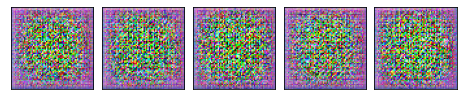

In [10]:
samples = gen.sample(5, with_grad=False)
test.assertSequenceEqual(samples.shape, (5, *x0.shape[1:]))
test.assertIsNone(samples.grad_fn)
_ = plot.tensors_as_images(samples.cpu())

samples = gen.sample(5, with_grad=True)
test.assertSequenceEqual(samples.shape, (5, *x0.shape[1:]))
test.assertIsNotNone(samples.grad_fn)

### Training
<a id=part3_7></a>

Training GANs is a bit different since we need to train two models simultaneously, each with it's own separate loss function and optimizer. We'll implement the training logic as a function that handles one batch of data
and updates both the discriminator and the generator based on it.

As mentioned above, GANs are considered hard to train. To get some ideas and tips you can see this [paper](https://arxiv.org/pdf/1606.03498.pdf), this list of ["GAN hacks"](https://github.com/soumith/ganhacks) or just do it the hard way :)

**TODO**:
1. Implement the `train_batch` function in the `hw3/gan.py` module.
2. Tweak the hyperparameters in the `part3_gan_hyperparams()` function within the `hw3/answers.py` module.

In [11]:
import torch.optim as optim
from torch.utils.data import DataLoader
from hw3.answers import part3_gan_hyperparams

torch.manual_seed(42)

# Hyperparams
hp = part3_gan_hyperparams()
batch_size = hp['batch_size']
z_dim = hp['z_dim']

# Data
dl_train = DataLoader(ds_gwb, batch_size, shuffle=True)
im_size = ds_gwb[0][0].shape

# Model
dsc = gan.Discriminator(im_size).to(device)
gen = gan.Generator(z_dim, featuremap_size=4).to(device)

# Optimizer
def create_optimizer(model_params, opt_params):
    opt_params = opt_params.copy()
    optimizer_type = opt_params['type']
    opt_params.pop('type')
    return optim.__dict__[optimizer_type](model_params, **opt_params)
dsc_optimizer = create_optimizer(dsc.parameters(), hp['discriminator_optimizer'])
gen_optimizer = create_optimizer(gen.parameters(), hp['generator_optimizer'])

# Loss
def dsc_loss_fn(y_data, y_generated):
    return gan.discriminator_loss_fn(y_data, y_generated, hp['data_label'], hp['label_noise'])

def gen_loss_fn(y_generated):
    return gan.generator_loss_fn(y_generated, hp['data_label'])

# Training
checkpoint_file = 'checkpoints/gan'
checkpoint_file_final = f'{checkpoint_file}_final'
if os.path.isfile(f'{checkpoint_file}.pt'):
    os.remove(f'{checkpoint_file}.pt')

# Show hypers
print(hp)

{'batch_size': 16, 'z_dim': 256, 'data_label': 1, 'label_noise': 0.1, 'discriminator_optimizer': {'type': 'Adam', 'lr': 0.0003}, 'generator_optimizer': {'type': 'Adam', 'lr': 0.0003}}


**TODO**:
1. Implement the `save_checkpoint` function in the `hw3.gan` module. You can decide on your own criterion regarding whether to save a checkpoint at the end of each epoch.
1. Run the following block to train. It will sample some images from your model every few epochs so you can see the progress.
2. When you're satisfied with your results, rename the checkpoints file by adding `_final`. When you run the `main.py` script to generate your submission, the final checkpoints file will be loaded instead of running training. Note that your final submission zip will not include the `checkpoints/` folder. This is OK.

--- EPOCH 1/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:04<00:00,  8.38it/s]
Discriminator loss: 0.5175848620779374
Generator loss:     2.22126247251735
0.5175848620779374
2.22126247251735


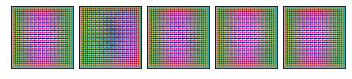

--- EPOCH 2/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 18.23it/s]
Discriminator loss: 0.19736158267101822
Generator loss:     3.6057669555439666
0.3574732223744778
2.9135147140306583


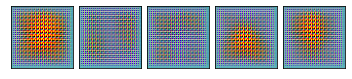

--- EPOCH 3/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 19.22it/s]
Discriminator loss: 0.09511687168303658
Generator loss:     3.9338808831046608
0.27002110547733077
3.2536367703886593


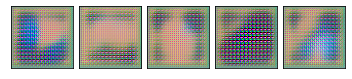

--- EPOCH 4/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 19.30it/s]
Discriminator loss: 0.056410507162046784
Generator loss:     4.469457268714905
0.21661845589850975
3.5575918949702205


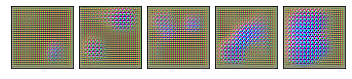

--- EPOCH 5/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 18.03it/s]
Discriminator loss: 0.01452795509248972
Generator loss:     5.0048090570113235
0.17620035573730575
3.8470353273784412


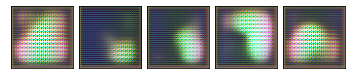

--- EPOCH 6/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 19.33it/s]
Discriminator loss: 0.04088536822510993
Generator loss:     4.989833270802217
0.15364785781860643
4.037501651282404


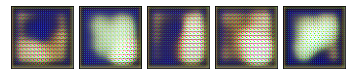

--- EPOCH 7/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 19.39it/s]
Discriminator loss: 0.025547578766503754
Generator loss:     5.571981093462775
0.13534781795402034
4.2567130001653135


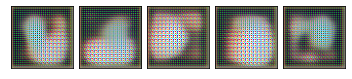

--- EPOCH 8/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 18.84it/s]
Discriminator loss: 0.035540360053453374
Generator loss:     5.684225180569817
0.12287188571644947
4.435152022715877


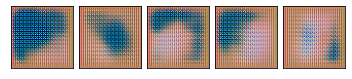

--- EPOCH 9/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 19.36it/s]
Discriminator loss: 0.06518877018243074
Generator loss:     4.640396889518289
0.11646265065711406
4.4579570079161455


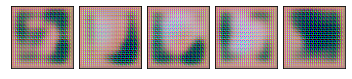

--- EPOCH 10/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 19.12it/s]
Discriminator loss: 0.043215472086825794
Generator loss:     5.092911103192498
0.10913793280008524
4.521452417443781


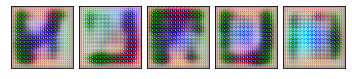

--- EPOCH 11/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 17.40it/s]
Discriminator loss: 0.043013121590346974
Generator loss:     5.838092888102812
0.10312658632647266
4.641147005685511


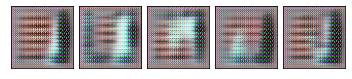

--- EPOCH 12/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 18.88it/s]
Discriminator loss: 0.04033730102374273
Generator loss:     5.404474945629344
0.0978941458845785
4.704757667347497


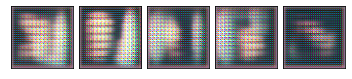

--- EPOCH 13/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 19.29it/s]
Discriminator loss: 0.04045950944590218
Generator loss:     5.516022443771362
0.09347609692775724
4.7671626501493325


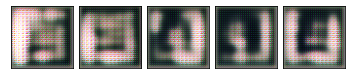

--- EPOCH 14/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 19.41it/s]
Discriminator loss: 0.05676600901300416
Generator loss:     5.370558612486896
0.09085394779098917
4.810262361744874


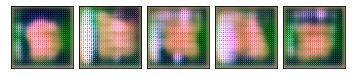

--- EPOCH 15/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 19.64it/s]
Discriminator loss: 0.0502622692626627
Generator loss:     5.703337094363044
0.08814783588910073
4.869800677252752


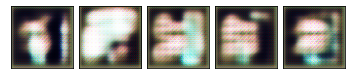

--- EPOCH 16/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 19.15it/s]
Discriminator loss: 0.09670179222217377
Generator loss:     4.904074472539565
0.08868245815991779
4.871942789458178


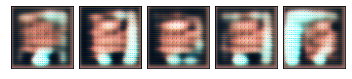

--- EPOCH 17/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 19.07it/s]
Discriminator loss: 0.07769605818697635
Generator loss:     5.274515011731316
0.08803619933798006
4.8956235084154205


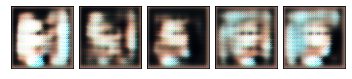

--- EPOCH 18/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 17.15it/s]
Discriminator loss: 0.06511516685542815
Generator loss:     5.252303740557502
0.08676280864450496
4.915439076867759


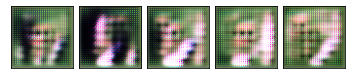

--- EPOCH 19/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 19.52it/s]
Discriminator loss: 0.06866815080866218
Generator loss:     5.9537475249346565
0.08581045823209217
4.970086889923912


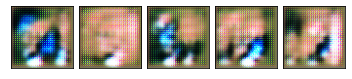

--- EPOCH 20/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 20.15it/s]
Discriminator loss: 0.062006771509699965
Generator loss:     5.405835649546455
0.08462027389597257
4.991874327905039


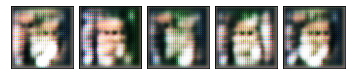

--- EPOCH 21/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 19.55it/s]
Discriminator loss: 0.03054352101924665
Generator loss:     5.3122452146866745
0.08204519042565228
5.00713008441845


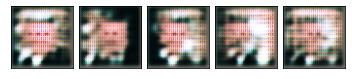

--- EPOCH 22/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 18.98it/s]
Discriminator loss: 0.030350022264482343
Generator loss:     5.926678012399113
0.07969541005469001
5.04892771750848


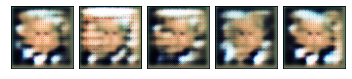

--- EPOCH 23/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 18.86it/s]
Discriminator loss: 0.10179565425085671
Generator loss:     5.508138838936301
0.08065629023713204
5.068893418440124


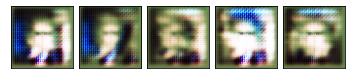

--- EPOCH 24/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 19.02it/s]
Discriminator loss: 0.0723564103793572
Generator loss:     5.5074966164196235
0.08031046190972475
5.08716855168927


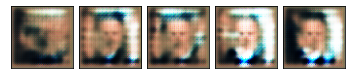

--- EPOCH 25/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 18.10it/s]
Discriminator loss: 0.051158869995132965
Generator loss:     5.916917169795317
0.07914439823314108
5.1203584964135125


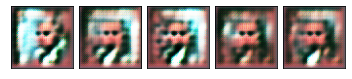

--- EPOCH 26/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 17.43it/s]
Discriminator loss: 0.05578252936110777
Generator loss:     5.467819788876702
0.07824586481498595
5.133722392277481


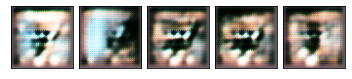

--- EPOCH 27/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 19.85it/s]
Discriminator loss: 0.0364178383092889
Generator loss:     4.835999867495368
0.07669667864810828
5.122695632100366


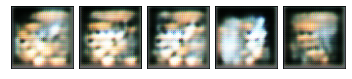

--- EPOCH 28/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 19.77it/s]
Discriminator loss: 0.04192739080035073
Generator loss:     5.333408524008358
0.07545491836783122
5.130221092525651


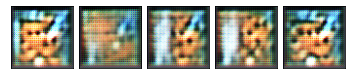

--- EPOCH 29/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 19.77it/s]
Discriminator loss: 0.03553152749972308
Generator loss:     6.3900617150699395
0.0740782497172068
5.1736638726133855


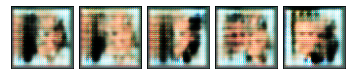

--- EPOCH 30/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 20.07it/s]
Discriminator loss: 0.10150014033869785
Generator loss:     6.178555011749268
0.07499231273792316
5.207160243917914


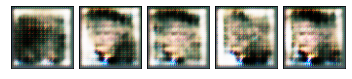

--- EPOCH 31/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 19.69it/s]
Discriminator loss: 0.1431673793670009
Generator loss:     5.622052799252903
0.07719150843563535
5.2205438747351725


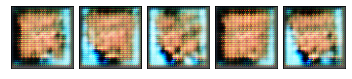

--- EPOCH 32/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 19.87it/s]
Discriminator loss: 0.05334798523279674
Generator loss:     5.36924306084128
0.07644639833554664
5.2251907243009885


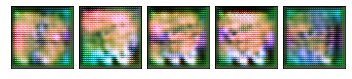

--- EPOCH 33/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 19.89it/s]
Discriminator loss: 0.033997885526760536
Generator loss:     5.484682104166816
0.07516007976558343
5.233054099448438


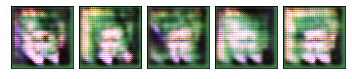

--- EPOCH 34/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 19.92it/s]
Discriminator loss: 0.02361455121461083
Generator loss:     6.369361428653493
0.07364403480820188
5.266474903248586


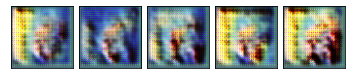

--- EPOCH 35/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 19.87it/s]
Discriminator loss: 0.03136205248644247
Generator loss:     5.6337151106666115
0.07243597817043733
5.276967480603386


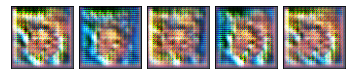

--- EPOCH 36/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 20.00it/s]
Discriminator loss: 0.05817276694099693
Generator loss:     6.41580794839298
0.07203977785850842
5.308601938041986


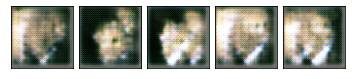

--- EPOCH 37/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 19.36it/s]
Discriminator loss: 0.05942360995173016
Generator loss:     5.821211029501522
0.07169880034751441
5.322456237811163


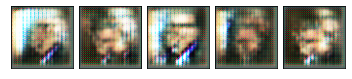

--- EPOCH 38/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 19.10it/s]
Discriminator loss: 0.07585472175303627
Generator loss:     6.16397280552808
0.0718081667002913
5.344601410645819


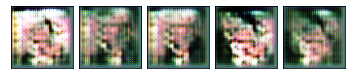

--- EPOCH 39/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 19.72it/s]
Discriminator loss: 0.10430190613602891
Generator loss:     5.99927599289838
0.07264133950633586
5.361387938395884


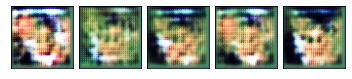

--- EPOCH 40/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 19.80it/s]
Discriminator loss: 0.04999255931333584
Generator loss:     5.495711978744058
0.07207512000151085
5.364746039404588


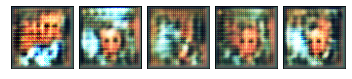

--- EPOCH 41/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 20.02it/s]
Discriminator loss: 0.04922934709226384
Generator loss:     5.49604741264792
0.07151790602811459
5.367948511922719


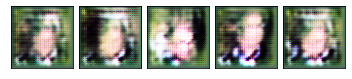

--- EPOCH 42/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 19.64it/s]
Discriminator loss: 0.09651747030918212
Generator loss:     5.752376710667329
0.07211313374909238
5.377101564273781


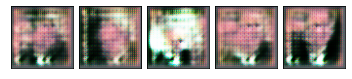

--- EPOCH 43/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 19.85it/s]
Discriminator loss: 0.0772090888417819
Generator loss:     6.086754055584178
0.0722316443326433
5.393605110583326


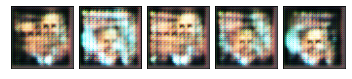

--- EPOCH 44/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 20.07it/s]
Discriminator loss: 0.03950332242118962
Generator loss:     5.8178690040812775
0.07148781883465571
5.403247471799188


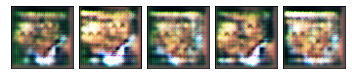

--- EPOCH 45/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 20.04it/s]
Discriminator loss: 0.08602098287904963
Generator loss:     5.579213643775267
0.07181077803564224
5.407157831176434


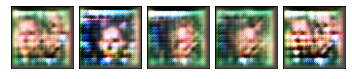

--- EPOCH 46/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 19.87it/s]
Discriminator loss: 0.12092134701635908
Generator loss:     6.079480598954594
0.07287839910044044
5.421773543519437


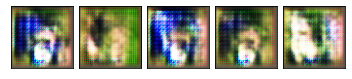

--- EPOCH 47/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 20.11it/s]
Discriminator loss: 0.07800289448898505
Generator loss:     6.281612746855792
0.07298743091721799
5.440067994654253


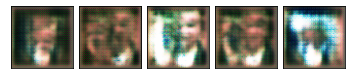

--- EPOCH 48/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 20.19it/s]
Discriminator loss: 0.0505705313921413
Generator loss:     5.235634095528546
0.07252041217711223
5.435808955089134


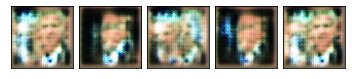

--- EPOCH 49/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 20.12it/s]
Discriminator loss: 0.07015532731790752
Generator loss:     4.953639331985922
0.07247214513916928
5.425968758699272


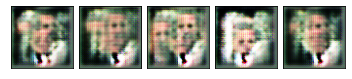

--- EPOCH 50/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 20.26it/s]
Discriminator loss: 0.051584295298465914
Generator loss:     5.679750758058884
0.07205438814235521
5.431044398686465


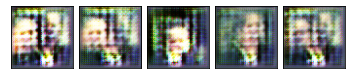

--- EPOCH 51/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 20.11it/s]
Discriminator loss: 0.08649192903848256
Generator loss:     6.402019577867844
0.07233747717953418
5.450083127690022


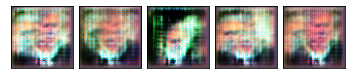

--- EPOCH 52/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 20.07it/s]
Discriminator loss: 0.04282955647281864
Generator loss:     6.045730717041913
0.0717700171659435
5.461537889023712


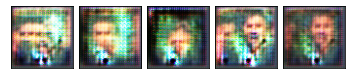

--- EPOCH 53/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 20.13it/s]
Discriminator loss: 0.059681480695657874
Generator loss:     5.519481995526482
0.07154193157216453
5.462631174052066


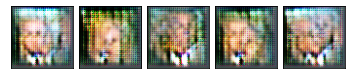

--- EPOCH 54/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 20.14it/s]
Discriminator loss: 0.08938207449939321
Generator loss:     6.188009472454295
0.07187230458933543
5.4760641055039585


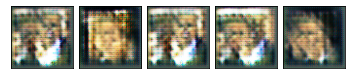

--- EPOCH 55/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 19.99it/s]
Discriminator loss: 0.10331067284021307
Generator loss:     5.6232384793898635
0.07244391128480593
5.478740003210975


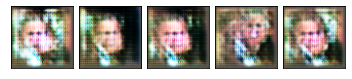

--- EPOCH 56/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 20.15it/s]
Discriminator loss: 0.09611549754353131
Generator loss:     5.956066433121176
0.07286661818228315
5.487263689459371


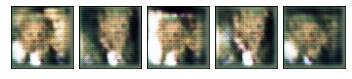

--- EPOCH 57/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 20.01it/s]
Discriminator loss: 0.10190348688732176
Generator loss:     6.56156825318056
0.07337603693149436
5.506111137945708


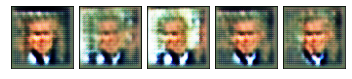

--- EPOCH 58/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 20.08it/s]
Discriminator loss: 0.10081184299334008
Generator loss:     7.274167537689209
0.0738490680704917
5.536594868975768


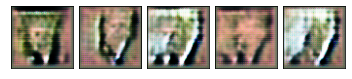

--- EPOCH 59/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 20.26it/s]
Discriminator loss: 0.06009284034371376
Generator loss:     6.109283307019402
0.07361591166834293
5.546301452671423


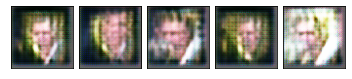

--- EPOCH 60/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 20.20it/s]
Discriminator loss: 0.08323965281905497
Generator loss:     6.430552559740403
0.07377630735418812
5.5610389711225725


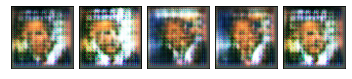

--- EPOCH 61/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 20.23it/s]
Discriminator loss: 0.16381720973945715
Generator loss:     5.957160437808318
0.07525238772115973
5.567532765658405


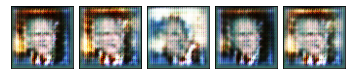

--- EPOCH 62/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 20.14it/s]
Discriminator loss: 0.10755229519461007
Generator loss:     5.835110755527721
0.07577335397073152
5.571848539688554


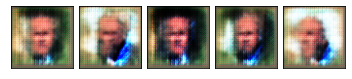

--- EPOCH 63/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 19.96it/s]
Discriminator loss: 0.06632115111193236
Generator loss:     6.6768043111352355
0.07562331900471883
5.589387520187708


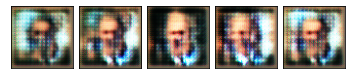

--- EPOCH 64/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 20.13it/s]
Discriminator loss: 0.15838018943117382
Generator loss:     6.787120566648595
0.0769163951051322
5.60810209903866


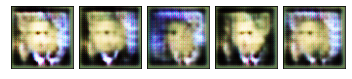

--- EPOCH 65/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 20.17it/s]
Discriminator loss: 0.09303618321085677
Generator loss:     6.007624289568732
0.07716439184522027
5.614248594277584


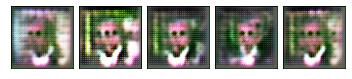

--- EPOCH 66/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 20.20it/s]
Discriminator loss: 0.08933851013288778
Generator loss:     6.031678606482113
0.0773488481829122
5.620573291432198


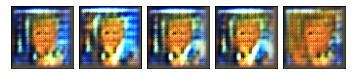

--- EPOCH 67/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 18.74it/s]
Discriminator loss: 0.009711924091200618
Generator loss:     6.171188873403213
0.07633934185318515
5.628791434446691


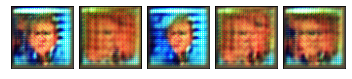

--- EPOCH 68/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 19.78it/s]
Discriminator loss: 0.024772000882555458
Generator loss:     5.685073221431059
0.07558099860361707
5.629619107784697


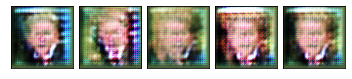

--- EPOCH 69/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 19.89it/s]
Discriminator loss: 0.06039450114921612
Generator loss:     6.018767083392424
0.07536090443761126
5.635258933518142


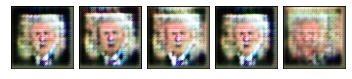

--- EPOCH 70/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 19.72it/s]
Discriminator loss: 0.11117277173873256
Generator loss:     6.763870379504035
0.07587250254191298
5.651381954175084


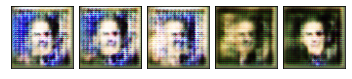

--- EPOCH 71/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 18.11it/s]
Discriminator loss: 0.031500953359200674
Generator loss:     7.101180455263923
0.07524755114497338
5.671801651373518


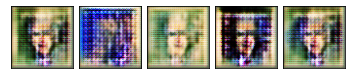

--- EPOCH 72/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 16.87it/s]
Discriminator loss: 0.07280381808660048
Generator loss:     7.224392638486974
0.07521361040805154
5.693365415083427


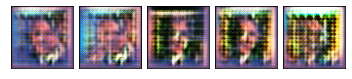

--- EPOCH 73/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 17.43it/s]
Discriminator loss: 0.04255506527774474
Generator loss:     5.730673937236562
0.0747662330774994
5.693876490729361


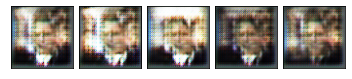

--- EPOCH 74/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 17.68it/s]
Discriminator loss: 0.06376183372648324
Generator loss:     6.4757366320666145
0.07461752497816133
5.7044421683149995


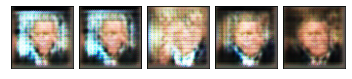

--- EPOCH 75/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 17.22it/s]
Discriminator loss: 0.05277113928733503
Generator loss:     7.7033796731163475
0.07432623983561698
5.731094668379018


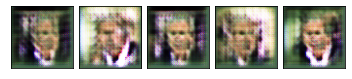

--- EPOCH 76/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 18.22it/s]
Discriminator loss: 0.08588428335154757
Generator loss:     6.830786480623133
0.07447831935556344
5.745564297487493


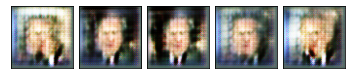

--- EPOCH 77/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 19.00it/s]
Discriminator loss: 0.09981606582946637
Generator loss:     6.549262123949387
0.07480738099808165
5.756001931597388


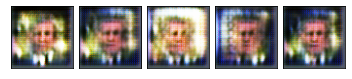

--- EPOCH 78/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 18.95it/s]
Discriminator loss: 0.08201015132534153
Generator loss:     7.133727662703571
0.07489972420740551
5.773665081996185


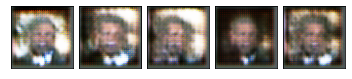

--- EPOCH 79/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 19.38it/s]
Discriminator loss: 0.10748321954708766
Generator loss:     5.594285530202529
0.07531217351550275
5.7713944547582905


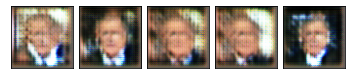

--- EPOCH 80/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 17.95it/s]
Discriminator loss: 0.12829368599854848
Generator loss:     6.623597131055944
0.07597444242154082
5.782046988212011


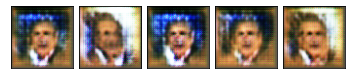

--- EPOCH 81/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 18.51it/s]
Discriminator loss: 0.14963660772670717
Generator loss:     7.9576380673576805
0.07688385186975276
5.8089061373372655


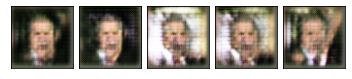

--- EPOCH 82/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 18.64it/s]
Discriminator loss: 0.040896045838427895
Generator loss:     7.323531178867116
0.07644497618644391
5.827377174429094


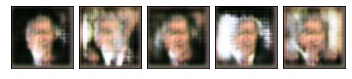

--- EPOCH 83/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 19.36it/s]
Discriminator loss: 0.08790434776421856
Generator loss:     6.839640498161316
0.07658304090424843
5.839573118088518


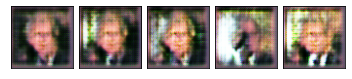

--- EPOCH 84/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 19.66it/s]
Discriminator loss: 0.14459200680036755
Generator loss:     6.6826410433825325
0.0773926714506308
5.849609641008685


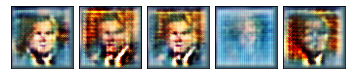

--- EPOCH 85/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 19.87it/s]
Discriminator loss: 0.08844088905436151
Generator loss:     8.810149006983814
0.07752265048126292
5.88443951590251


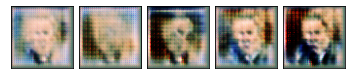

--- EPOCH 86/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 18.77it/s]
Discriminator loss: 0.032396655214731306
Generator loss:     5.572548901333528
0.0769979296060707
5.880812880849382


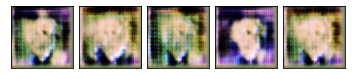

--- EPOCH 87/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 19.21it/s]
Discriminator loss: 0.04860853269586668
Generator loss:     5.810047724667718
0.07667161469905685
5.8799994882495925


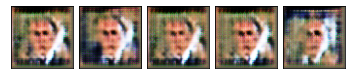

--- EPOCH 88/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 19.52it/s]
Discriminator loss: 0.0826405783129089
Generator loss:     5.865998997407801
0.07673944383103246
5.879840391762754


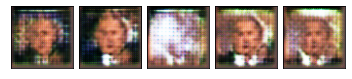

--- EPOCH 89/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 18.78it/s]
Discriminator loss: 0.19988822005689144
Generator loss:     7.4418487654012795
0.07812313794592975
5.897391047646332


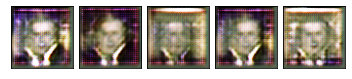

--- EPOCH 90/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 18.99it/s]
Discriminator loss: 0.09373087162042365
Generator loss:     5.698231809279498
0.07829655720897968
5.895178167220034


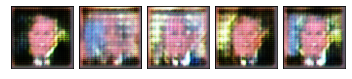

--- EPOCH 91/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 18.31it/s]
Discriminator loss: 0.09978831143063657
Generator loss:     6.233710793887868
0.07853273033229459
5.898898305974626


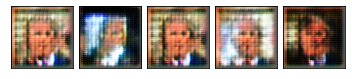

--- EPOCH 92/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 18.66it/s]
Discriminator loss: 0.11902989353984594
Generator loss:     6.633172960842357
0.0789729168888984
5.906879552223188


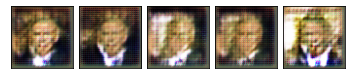

--- EPOCH 93/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 19.34it/s]
Discriminator loss: 0.08832748321925893
Generator loss:     6.119097856914296
0.07907350362363347
5.909161469477931


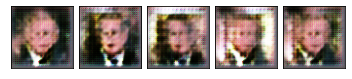

--- EPOCH 94/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 19.33it/s]
Discriminator loss: 0.0880877659382189
Generator loss:     6.024806415333467
0.07916940003123545
5.910391734859374


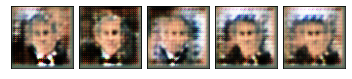

--- EPOCH 95/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 19.39it/s]
Discriminator loss: 0.14414611729957602
Generator loss:     5.905044429442462
0.07985336547616534
5.9103354474339325


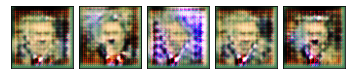

--- EPOCH 96/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 18.87it/s]
Discriminator loss: 0.06404467946028009
Generator loss:     5.746010415694293
0.07968869166349987
5.908623728353311


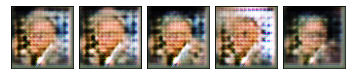

--- EPOCH 97/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 18.40it/s]
Discriminator loss: 0.09954014278071768
Generator loss:     5.246098672642427
0.07989334579872892
5.9017935731397975


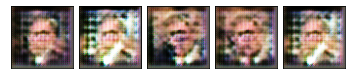

--- EPOCH 98/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 19.52it/s]
Discriminator loss: 0.09450498152085963
Generator loss:     5.420335362939274
0.08004244412242414
5.8968807342602


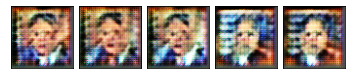

--- EPOCH 99/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 19.03it/s]
Discriminator loss: 0.09540287821608431
Generator loss:     7.2087582490023445
0.08019760002236011
5.910132022287898


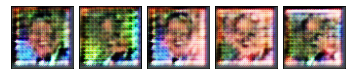

--- EPOCH 100/100 ---
100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 18.30it/s]
Discriminator loss: 0.06017289902357494
Generator loss:     5.405147440293256
0.07999735301237226
5.9050821764679515


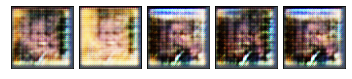

In [12]:
import IPython.display
import tqdm
from hw3.gan import train_batch, save_checkpoint

num_epochs = 100

if os.path.isfile(f'{checkpoint_file_final}.pt'):
    print(f'*** Loading final checkpoint file {checkpoint_file_final} instead of training')
    num_epochs = 0
    gen = torch.load(f'{checkpoint_file_final}.pt', map_location=device)
    checkpoint_file = checkpoint_file_final

try:
    dsc_avg_losses, gen_avg_losses = [], []
    for epoch_idx in range(num_epochs):
        # We'll accumulate batch losses and show an average once per epoch.
        dsc_losses, gen_losses = [], []
        print(f'--- EPOCH {epoch_idx+1}/{num_epochs} ---')

        with tqdm.tqdm(total=len(dl_train.batch_sampler), file=sys.stdout) as pbar:
            for batch_idx, (x_data, _) in enumerate(dl_train):
                x_data = x_data.to(device)
                dsc_loss, gen_loss = train_batch(
                    dsc, gen,
                    dsc_loss_fn, gen_loss_fn,
                    dsc_optimizer, gen_optimizer,
                    x_data)
                dsc_losses.append(dsc_loss)
                gen_losses.append(gen_loss)
                pbar.update()

        dsc_avg_losses.append(np.mean(dsc_losses))
        gen_avg_losses.append(np.mean(gen_losses))
        print(f'Discriminator loss: {dsc_avg_losses[-1]}')
        print(f'Generator loss:     {gen_avg_losses[-1]}')
        
        if save_checkpoint(gen, dsc_avg_losses, gen_avg_losses, checkpoint_file):
            print(f'Saved checkpoint.')
            

        samples = gen.sample(5, with_grad=False)
        fig, _ = plot.tensors_as_images(samples.cpu(), figsize=(6,2))
        IPython.display.display(fig)
        plt.close(fig)
except KeyboardInterrupt as e:
    print('\n *** Training interrupted by user')

*** Images Generated from best model:


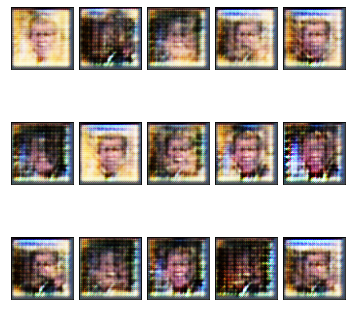

In [13]:
# Plot images from best or last model
if os.path.isfile(f'{checkpoint_file}.pt'):
    gen = torch.load(f'{checkpoint_file}.pt', map_location=device)
print('*** Images Generated from best model:')
samples = gen.sample(n=15, with_grad=False).cpu()
fig, _ = plot.tensors_as_images(samples, nrows=3, figsize=(6,6))

## Questions
<a id=part3_8></a>

**TODO** Answer the following questions. Write your answers in the appropriate variables in the module `hw3/answers.py`.

In [14]:
from cs236781.answers import display_answer
import hw3.answers

### Question 1

Explain in detail why during training we sometimes need to maintain gradients when sampling from the GAN,
and other times we don't. When are they maintained and why? When are they discarded and why?

In [15]:
display_answer(hw3.answers.part3_q1)


**Your answer:**


Write your answer using **markdown** and $\LaTeX$:
```python
# A code block
a = 2
```
An equation: $e^{i\pi} -1 = 0$



### Question 2

1. When training a GAN to generate images, should we decide to stop training solely based on the fact that  the Generator loss is below some threshold?
Why or why not?

2. What does it mean if the discriminator loss remains at a constant value while the generator loss decreases?

In [16]:
display_answer(hw3.answers.part3_q2)


**Your answer:**


Write your answer using **markdown** and $\LaTeX$:
```python
# A code block
a = 2
```
An equation: $e^{i\pi} -1 = 0$



### Question 3

Compare the results you got when generating images with the VAE to the GAN results.
What's the main difference and what's causing it?

In [17]:
display_answer(hw3.answers.part3_q3)


**Your answer:**


Write your answer using **markdown** and $\LaTeX$:
```python
# A code block
a = 2
```
An equation: $e^{i\pi} -1 = 0$

